K-Means Clustering Stock Data with Silhouette Value

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
# Get 5 years of data for AAPL
start_date = '2018-10-23'
end_date = '2023-10-23'
aapl = yf.download('AAPL', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Create a DataFrame and calculate the required columns
df = pd.DataFrame(aapl)
df['Close/30Day_MA'] = df['Close'] / df['Close'].rolling(window = 30).mean()
df['Future_5day_Percent_Change'] = df['Close'].pct_change(periods = 5).shift(-5)
df['30Day_Rolling_Volatility'] = df['Close'].pct_change().rolling(window = 30).std()

In [4]:
# Drop rows with NaN values
df = df.dropna()

In [5]:
# Prepare data for clustering
X = df[['Volume','Close/30Day_MA', 'Future_5day_Percent_Change', '30Day_Rolling_Volatility']]

In [6]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Determine optimal number of clusters using Elbow Method
sse = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


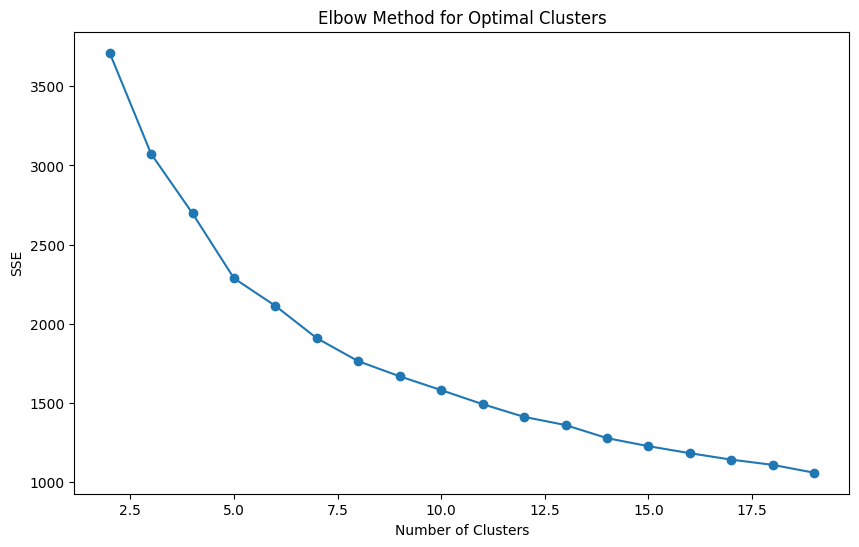

In [8]:
# Plot the SSE against the number of clusters
plt.figure(figsize = (10, 6))
plt.plot(range(2, 20), sse, marker = 'o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [9]:
# Re-fit the model with the optimal number of clusters based on the plot
optimal_clusters = 5
kmeans = KMeans(n_clusters = optimal_clusters, random_state = 0)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [10]:
# Show centroids in original scale
centroids = kmeans.cluster_centers_
dfcentroids = pd.DataFrame(centroids, columns = X.columns)
display(dfcentroids)

,Volume,Close/30Day_MA,Future_5day_Percent_Change,30Day_Rolling_Volatility
0,-0.503627,0.505281,0.178658,-0.564137
1,-0.183327,-0.613203,-0.999808,0.121684
2,1.115886,1.198297,0.114510,0.109063
3,2.478189,-1.272246,-0.094551,2.832249
4,-0.007844,-0.884419,1.010504,0.332236


In [11]:
# Transform centroids back to the original scale
original_scale_centroids = scaler.inverse_transform(centroids)
dforiginal_scale_centroids = pd.DataFrame(original_scale_centroids, columns = X.columns)
display(dforiginal_scale_centroids)

,Volume,Close/30Day_MA,Future_5day_Percent_Change,30Day_Rolling_Volatility
0,7.786015e+07,1.047077,0.014088,0.014443
1,9.508176e+07,0.979809,-0.034726,0.020233
2,1.649367e+08,1.088757,0.011431,0.020126
3,2.381838e+08,0.940172,0.002771,0.043116
4,1.045170e+08,0.963497,0.048544,0.022010


In [12]:
def plot_silhouettes(data, clusters):
    
    # Get the unique cluster labels and the number of clusters
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]

    # Calculate the silhouette values
    silhouette_vals = metrics.silhouette_samples(data, clusters, metric = 'euclidean')
    
    # Initialize variables to track the lower and upper bounds
    c_ax_lower, c_ax_upper = 0, 0

    # List to store the tick positions for cluster labels
    cticks = []

    for i, k in enumerate(cluster_labels):

        # Get the silhouette values for the current cluster 'k'
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()

        # Calculate the upper bound
        c_ax_upper += len(c_silhouette_vals)

        # Plot the horizontal bars for the current cluster's silhouette values
        color = cm.jet(float(i) / n_clusters)
        pl.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height = 1.0, edgecolor = 'none', color = color)

        # Append the center position for the current cluster
        cticks.append((c_ax_lower + c_ax_upper) / 2)

        # Update the lower bound
        c_ax_lower += len(c_silhouette_vals)
    
    # Calculate the average silhouette score
    silhouette_avg = np.mean(silhouette_vals)

    # Plot a vertical line at the average silhouette score
    print("The average silhouette value is:", str(silhouette_avg))
    pl.axvline(silhouette_avg, color = "red", linestyle = "--") 
    pl.yticks(cticks, cluster_labels)
    pl.ylabel('Cluster')
    pl.xlabel('Silhouette Coefficient')
    pl.tight_layout()
    pl.show()
    
    return

The number of clusters is: 2


The average silhouette value is: 0.3405625863764065


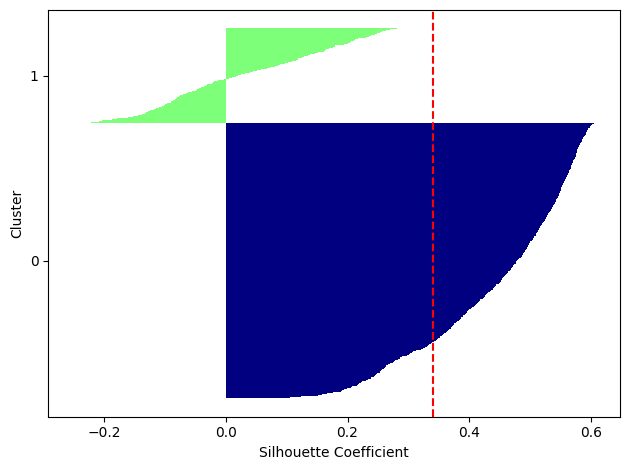

The number of clusters is: 3
The average silhouette value is: 0.23917841528703163


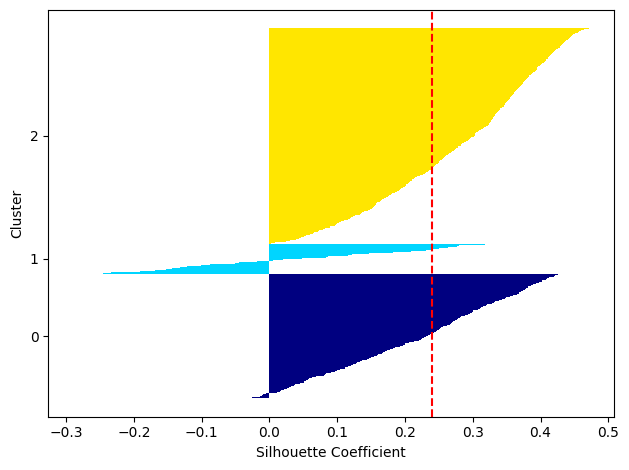

The number of clusters is: 4
The average silhouette value is: 0.24105988495288702


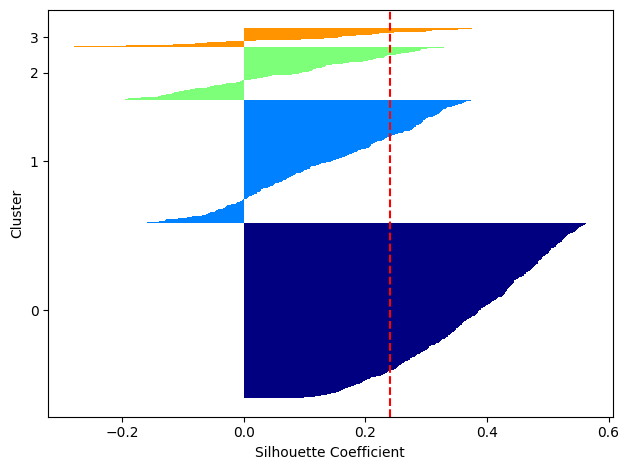

The number of clusters is: 5
The average silhouette value is: 0.2551551248886072


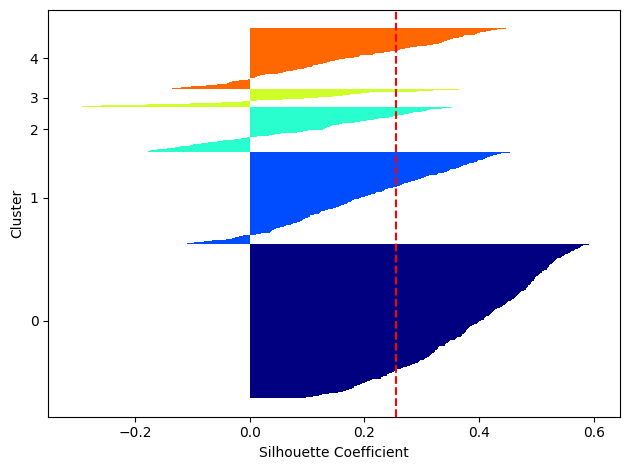

The number of clusters is: 6
The average silhouette value is: 0.22648827073365532


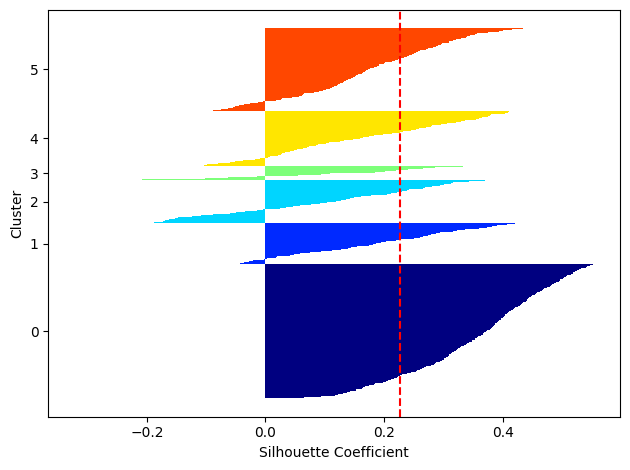

The number of clusters is: 7
The average silhouette value is: 0.24785925689076135


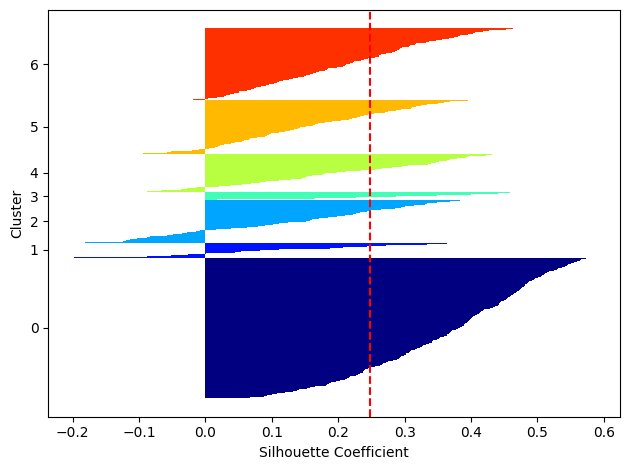

The number of clusters is: 8
The average silhouette value is: 0.20348186715883995


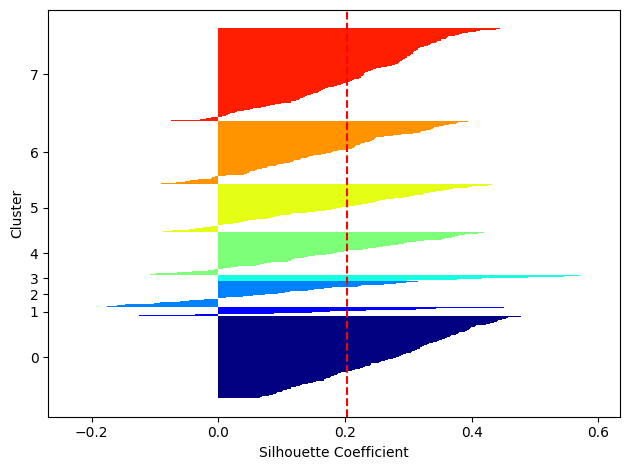

The number of clusters is: 9
The average silhouette value is: 0.19679900594784686


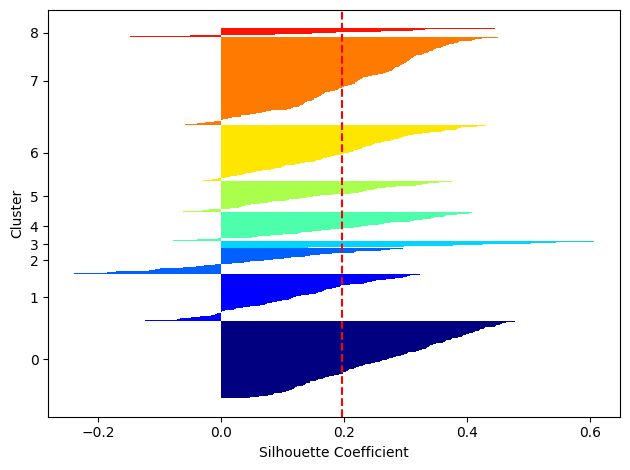

The number of clusters is: 10
The average silhouette value is: 0.2068130035064497


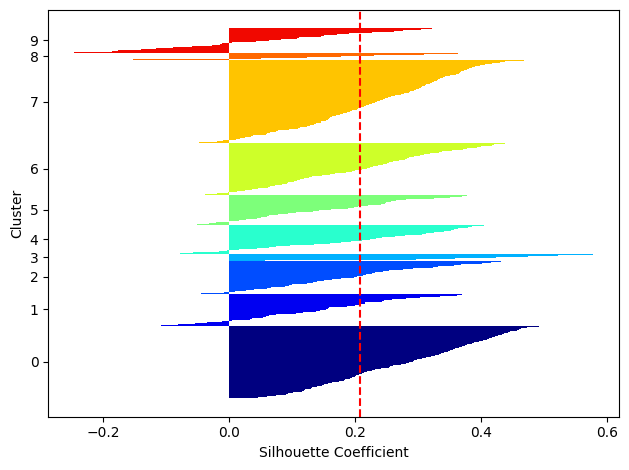

The number of clusters is: 11
The average silhouette value is: 0.20791187076592904


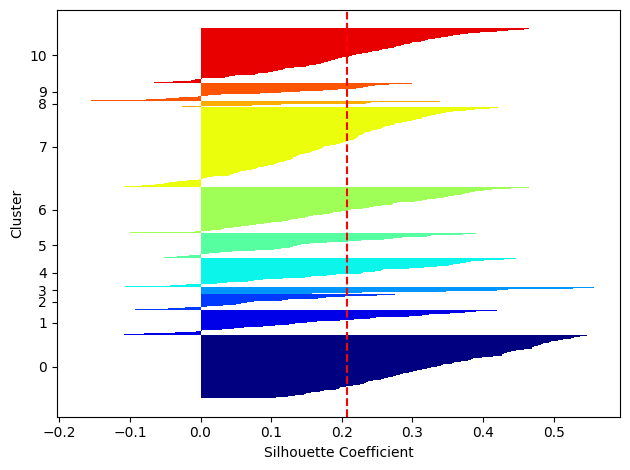

The number of clusters is: 12
The average silhouette value is: 0.20692671418956862


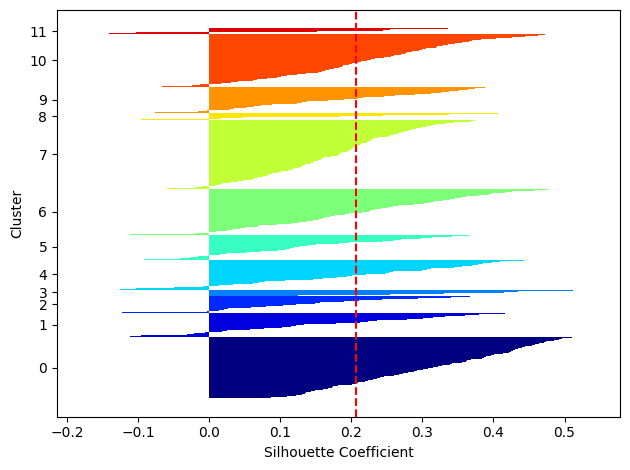

The number of clusters is: 13
The average silhouette value is: 0.206384974985816


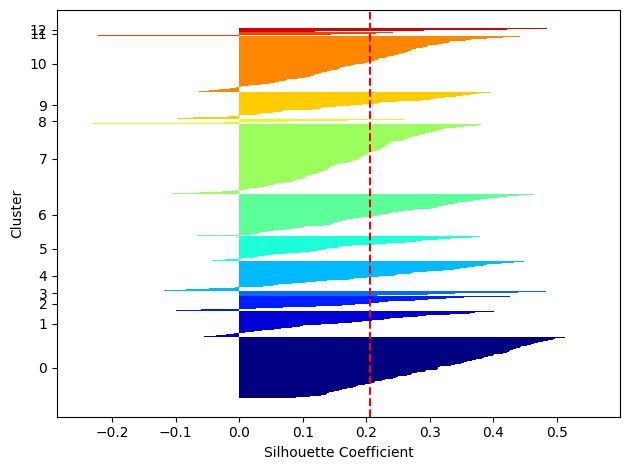

The number of clusters is: 14
The average silhouette value is: 0.2178900102587676


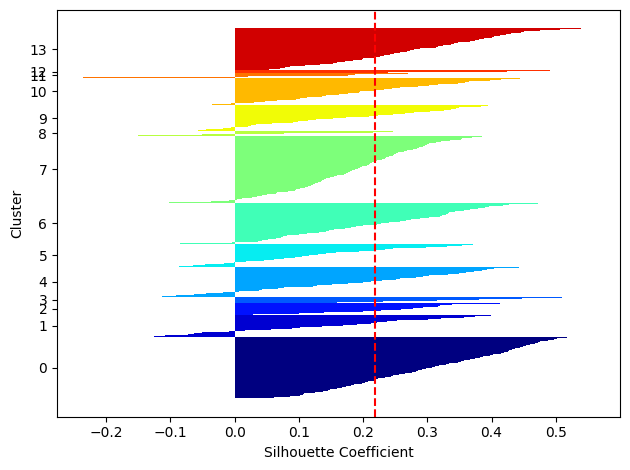

The number of clusters is: 15
The average silhouette value is: 0.2219938727179173


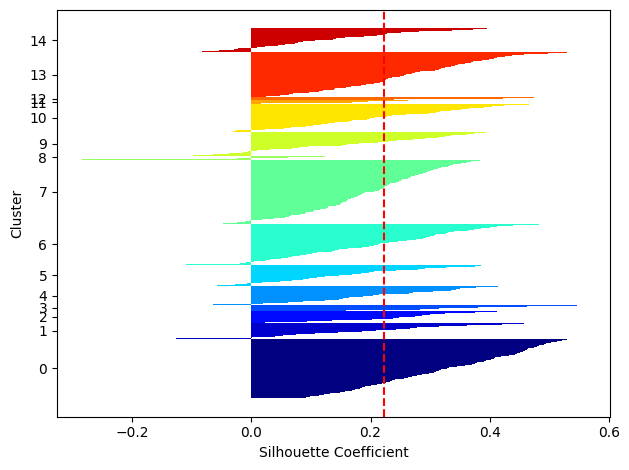

The number of clusters is: 16
The average silhouette value is: 0.22257200151557244


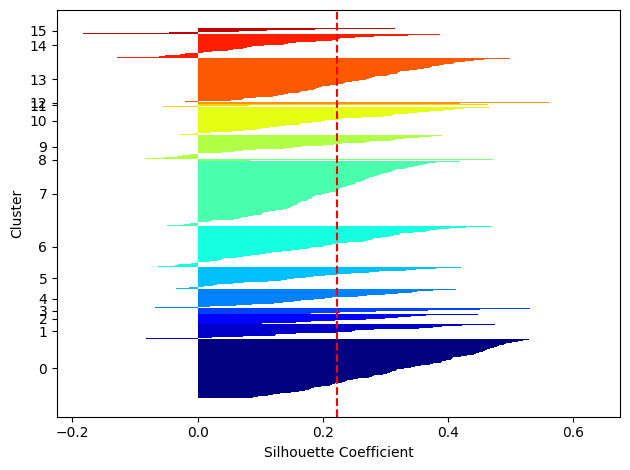

The number of clusters is: 17
The average silhouette value is: 0.2153439436001995


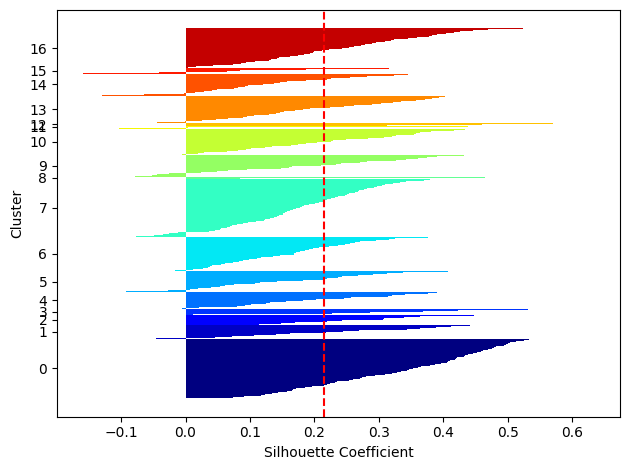

The number of clusters is: 18
The average silhouette value is: 0.21990872687551502


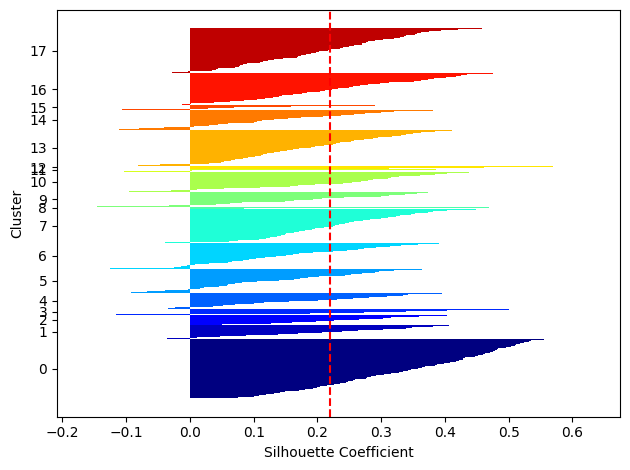

The number of clusters is: 19
The average silhouette value is: 0.22424957999557718


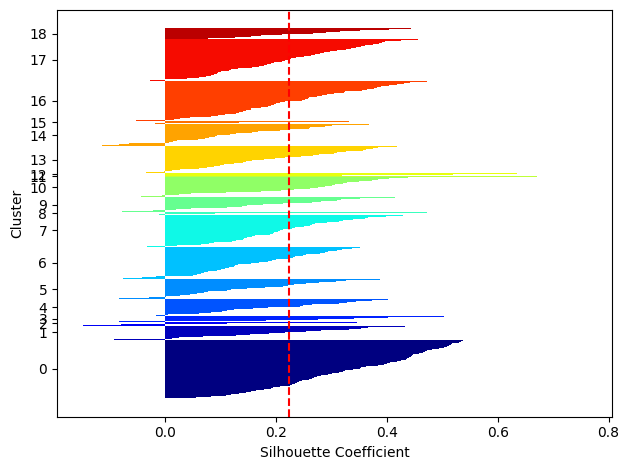

In [13]:
for k in range(2, 20):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(X_scaled)
    clusters = kmeans.predict(X_scaled)
    print("The number of clusters is:", str(k))
    plot_silhouettes(X_scaled, clusters)